# CO2

Monthly data over 14 years

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import itertools

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

## Load and Prepare Data

In [3]:
df = pd.read_excel("src/Monthly_CO2_Concentrations.xlsx")
display(df.shape)
df.isna().sum()
df = df.dropna()

(174, 3)

CO2      13
Year     13
Month    13
dtype: int64

In [4]:
df.Year = df.Year.astype(np.int32)
df.Month = df.Month.astype(np.int32)
df.sort_values(['Year', 'Month'], inplace=True)
print(df.head())

      CO2  Year  Month
0  333.13  1974      5
1  332.09  1974      6
2  331.10  1974      7
3  329.14  1974      8
4  327.36  1974      9


In [5]:
df["Date"] = df.apply(lambda row: "%4d-%02d" %  (row.Year, row.Month), axis=1)
df = df.set_index("Date")
print(df.head())

            CO2  Year  Month
Date                        
1974-05  333.13  1974      5
1974-06  332.09  1974      6
1974-07  331.10  1974      7
1974-08  329.14  1974      8
1974-09  327.36  1974      9


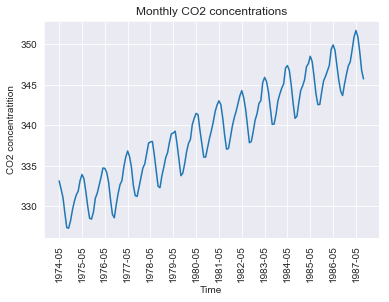

In [6]:
plt.plot(df.CO2)
plt.title('Monthly CO2 concentrations')
plt.ylabel('CO2 concentratition')
plt.xlabel('Time')
plt.xticks(rotation=90)
xticks = df.index.tolist()[0::12]
plt.xticks(xticks, xticks)
plt.savefig("pic/CO2_original.pdf", bbox_inches="tight")
plt.show() 

## Identify and Remove Trend using Regrssion

In [7]:
df = df.reset_index() 
print(df.head(5))

      Date     CO2  Year  Month
0  1974-05  333.13  1974      5
1  1974-06  332.09  1974      6
2  1974-07  331.10  1974      7
3  1974-08  329.14  1974      8
4  1974-09  327.36  1974      9


In [8]:
from sklearn.linear_model import LinearRegression
trend_model = LinearRegression(normalize=True, fit_intercept=True)
trend_model.fit(np.array(df.index).reshape(-1, 1), df['CO2'])
print('Trend model coefficient=%.3f and intercept=%.3f.'  % (trend_model.coef_[0], trend_model.intercept_))

Trend model coefficient=0.121 and intercept=329.453.


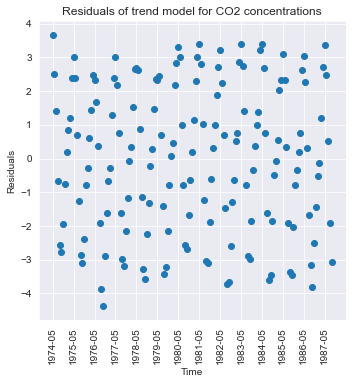

In [9]:
residuals = np.array(df['CO2']) - trend_model.predict(np.array(df.index).reshape((-1,1)))
plt.figure(figsize=(5.5, 5.5))

plt.plot(df.Date, residuals, 'o')
plt.title('Residuals of trend model for CO2 concentrations')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.xticks(rotation=90)
xticks = df.Date.tolist()[0::12]
plt.xticks(xticks, xticks)
plt.savefig("pic/CO2_trend_residuals_dots.pdf", bbox_inches="tight")
plt.show()

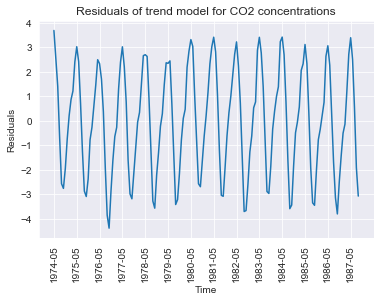

In [10]:
plt.plot(df.Date, residuals, '-')
plt.title('Residuals of trend model for CO2 concentrations')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.xticks(rotation=90)
xticks = df.Date.tolist()[0::12]
plt.xticks(xticks, xticks)
plt.savefig("pic/CO2_trend_residuals_lines.pdf", bbox_inches="tight")
plt.show()

Comparing the above two plots - we should always draw line between residual points to make it easier to see cycles.

## SARIMA

In [11]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [ (*x,12) for x in pdq]

bestModel = None
score = np.finfo(float).max

In [12]:
for param in pdq:   
    for param_seasonal in seasonal_pdq:
    
        # pre-saved optimum
        if not param==(0, 1, 1): continue
        if not param_seasonal==(2, 1, 3, 12): continue
        
        try:
            mod = sm.tsa.statespace.SARIMAX(df.CO2.values,
                order=param, seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic<score:
                bestModel = {'param':param, 'seasonal_param':param_seasonal}
                score = results.aic
        except:
            continue

print("Optimal model is ARIMA{} x {} - AIC: {}".format(bestModel["param"], bestModel["seasonal_param"], score))

ARIMA(0, 1, 1) x (2, 1, 3, 12) - AIC: 61.90334744858856
Optimal model is ARIMA(0, 1, 1) x (2, 1, 3, 12) - AIC: 61.90334744858856


In [13]:
model = sm.tsa.statespace.SARIMAX(df.CO2.values,
    order=(0,1,1), seasonal_order=(2,1,3,12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()

In [14]:
print(model.summary().tables[0])
print(model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  161
Model:             SARIMAX(0, 1, 1)x(2, 1, 3, 12)   Log Likelihood                 -23.952
Date:                            Mon, 25 Mar 2019   AIC                             61.903
Time:                                    06:49:04   BIC                             83.473
Sample:                                         0   HQIC                            70.662
                                            - 161                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5625      0.082     -6.827      0.000      -0.724      -0.401
ar.S.L12      -0.7741      0.340   

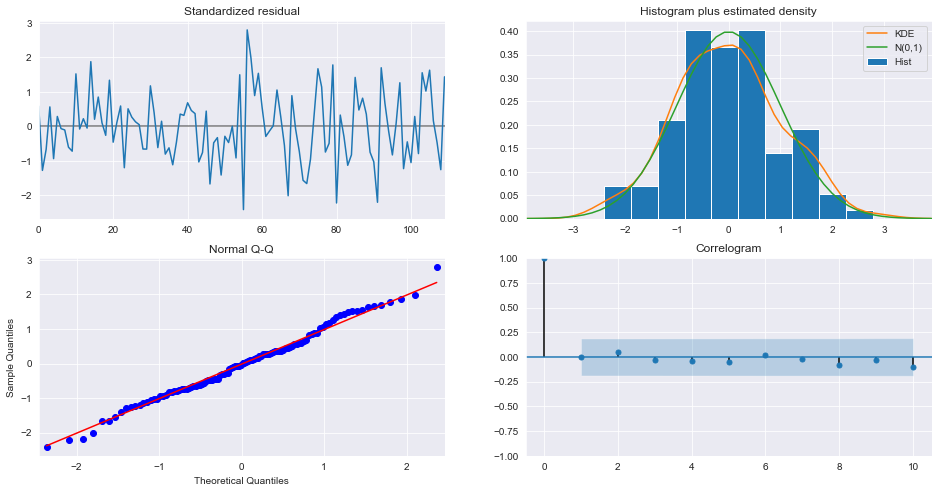

In [15]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig("pic/CO2_SARIMA.pdf", bbox_inches="tight")
plt.show()

# Alternative - Decomposition of Trend/Seasonal/Unexplained 

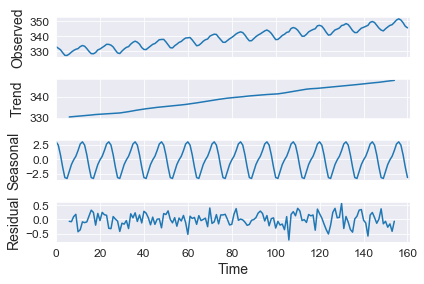

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.CO2.values, freq=12, model='additive')
#plt.figure(figsize=(10,10))
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
fig = decomposition.plot()
plt.show()